<a href="https://colab.research.google.com/github/suriya-mouli/CNN_Model/blob/main/Cat%26Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# STEP 0: SETUP & GPU CONFIGURATION

import tensorflow as tf
import os
import shutil
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models


In [ ]:
# Check GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("✅ GPU detected and memory growth enabled!")
else:
    print("⚠️ No GPU found — training will run on CPU.")

✅ GPU detected and memory growth enabled!


In [ ]:
#  STEP 1: DEFINE DATA PATHS
dataset_dir = "/content/drive/MyDrive/catsAnddogs"
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")

valid_extensions = ['.jpeg', '.jpg', '.bmp', '.png']

In [ ]:
#  STEP 2: COUNT IMAGES
def count_images_nested(directory):
    total_images = 0
    folder_counts = {}
    for root, dirs, files in os.walk(directory):
        valid_files = [f for f in files if os.path.splitext(f)[1].lower() in valid_extensions]
        if valid_files:
            folder_name = os.path.basename(root)
            folder_counts[folder_name] = folder_counts.get(folder_name, 0) + len(valid_files)
            total_images += len(valid_files)
    return folder_counts, total_images

before_counts, before_total = count_images_nested(dataset_dir)

print("📊 BEFORE CLEANING:")
print(f"Total Folders with Images: {len(before_counts)}")
for cls, count in before_counts.items():
    print(f"  - {cls}: {count} valid images")
print(f"Total Images: {before_total}")


📊 BEFORE CLEANING:
Total Folders with Images: 2
  - dogs: 348 valid images
  - cats: 349 valid images
Total Images: 697


In [ ]:

#  STEP 3: REMOVE INVALID FILE TYPES

def remove_invalid_files(directory):
    removed_files = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            ext = os.path.splitext(file)[1].lower()
            if ext not in valid_extensions:
                file_path = os.path.join(root, file)
                try:
                    os.remove(file_path)
                    removed_files += 1
                except Exception as e:
                    print(f"⚠️ Could not delete {file_path}: {e}")
    return removed_files

removed_files = remove_invalid_files(dataset_dir)
print(f"\n🧹 Cleanup complete! {removed_files} invalid files removed.")



🧹 Cleanup complete! 0 invalid files removed.


In [ ]:
#  STEP 4: RECOUNT AFTER CLEANING
after_counts, after_total = count_images_nested(dataset_dir)
print("\n📊 AFTER CLEANING:")
for cls, count in after_counts.items():
    print(f"  - {cls}: {count} valid images")
print(f"Total Images: {after_total}")



📊 AFTER CLEANING:
  - dogs: 348 valid images
  - cats: 349 valid images
Total Images: 697


In [ ]:
# Step 5: Verify Labels and Normalize
# Function to check that each image has the right label
def verify_labels(directory):
    print("Verifying labels...")
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    print(f"Skipping non-image file: {img_name}")
    print("Labels verification done.\n")

verify_labels(train_dir)
verify_labels(test_dir)

Verifying labels...
Labels verification done.

Verifying labels...
Labels verification done.



In [ ]:
# Step 6 : Load Datasets (with Validation Split)
img_size = (128, 128)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.15,   # 15% of training data for validation
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.15,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

Found 557 files belonging to 2 classes.
Using 474 files for training.
Found 557 files belonging to 2 classes.
Using 83 files for validation.
Found 140 files belonging to 2 classes.


In [ ]:
# Step 7: Normalize Images

train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

In [ ]:
# Step 8: Build Sequential CNN Model

num_classes = len(os.listdir(train_dir))

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Step 9: Compile Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Step 10: Train Model
# ------------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 101s 6s/step - accuracy: 0.5264 - loss: 0.8314 - val_accuracy: 0.5301 - val_loss: 0.6908
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.5182 - loss: 0.6981 - val_accuracy: 0.5301 - val_loss: 0.6903
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.5257 - loss: 0.6864 - val_accuracy: 0.6145 - val_loss: 0.6802
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.6201 - loss: 0.6733 - val_accuracy: 0.4699 - val_loss: 0.6908
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - accuracy: 0.5463 - loss: 0.6753 - val_accuracy: 0.5904 - val_loss: 0.6797
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.6420 - loss: 0.6196 - val_accuracy: 0.5542 - val_loss: 0.6770
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - accuracy: 0.7096 - loss: 0.5838 - val_accuracy: 0.6145 - val_loss: 0.6533
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 0.7183 - loss: 0.5579 - val_accuracy: 0.6

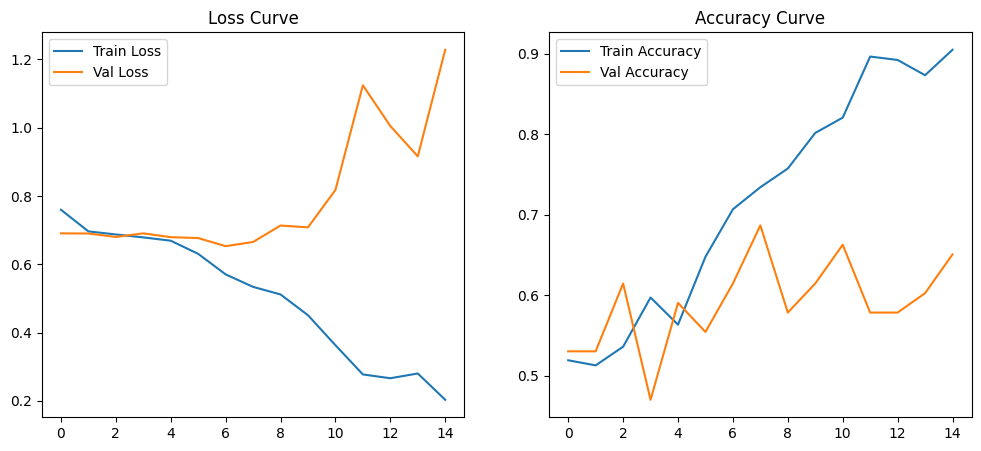

In [ ]:

# Step 11: Plot Loss and Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [ ]:
# ------------------------------
# Step 12: Evaluate Model
# ------------------------------
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.6475 - loss: 1.2214
Test Accuracy: 0.6286, Test Loss: 1.2642


In [ ]:
#Test
import os

train_dir = "/content/drive/MyDrive/catsAnddogs/train"
class_names = sorted(os.listdir(train_dir))  # folder names are your classes
print(class_names)  # e.g., ['cat', 'dog']




['cats', 'dogs']


In [ ]:


from tensorflow.keras.preprocessing import image
import numpy as np

img_path = "/content/drive/MyDrive/catsAnddogs/images.jpg"  # outside dataset

# Load and resize
img = image.load_img(img_path, target_size=(128,128))

# Convert to array and normalize
img_array = image.img_to_array(img) / 255.0

# Add batch dimension
img_array = np.expand_dims(img_array, axis=0)


In [ ]:
pred = model.predict(img_array)
pred_class = np.argmax(pred, axis=1)

print(f"Predicted class: {class_names[pred_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted class: cats


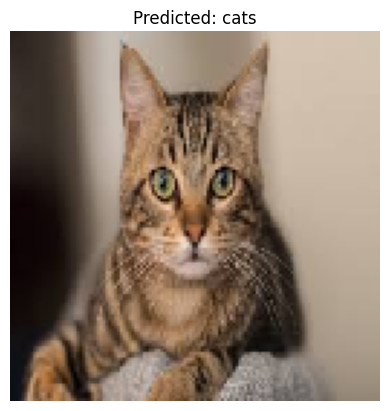

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(f"Predicted: {class_names[pred_class[0]]}")
plt.axis('off')
plt.show()
